# ORIE 4580/5580/5581 Assignment 4

#### Students: Boqian Niu (bn287)

### Github link: https://github.com/NBQian/ORIE-5581/blob/main/HW4.ipynb


### Instructions


* Due Thursday October 2, at 11.59pm on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/80773#:~:text=Assignments-,Assignments,-Assignments%20module%20publish).
* Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Gemini/Claude/ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**.
* You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.




### Suggested reading

Chapters 5 (sections 5.1, 5.2 and 5.3) and 6, as well as chapter 11 (to revise again what we discussed in class about confidence intervals) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).

<hr><hr>

# Question 1: The Inspection paradox (30 pts)

Have you ever felt like you wait too long for elevators, taxis, buses, etc.? Guess what - you may be right!

We are going to simulate a number of train and passenger arrivals at a station, and try to measure the time each passenger needs to wait for a train. To do this, first generate a stream of 10,000 train passengers, each of whom have an independent arrival time which is uniformly distributed over an interval of 1,000 minutes (i.e., passenger $i$ arrives at time $T_i\sim [0,1000]$. Sort the passengers by arrival time, and use this resulting vector for all subsequent parts.

<hr>

**(a)** Suppose trains arrive at the station deterministically every 10 minutes. Assume each train has infinite capacity, so that everyone waiting at the station when a train arrives can get on; also assume that passengers get on the train instantaneously. Estimate the expected time (with CIs) that any *randomly chosen* passenger spends waiting at the station for the next train.

<hr>

## Ans.

Pick a passenger arriving at time $T$ uniformly over a long window.  
Define the within-cycle arrival phase
$$
U := T \bmod 10 \in [0,10).
$$
Because $T$ has a constant density across many 10-minute cycles, 
$$
U \sim \text{Uniform}(0,10).
$$

The wait for the next train is
$$
W=\begin{cases}
0, & U=0,\\[2pt]
10-U, & 0<U<10,
\end{cases}
$$
and since $\mathbb{P}(U=0)=0$, we can take $W=10-U$. Hence
$$
W \sim \text{Uniform}(0,10).
$$

Using the uniform mean,
$$
\mathbb{E}[W]=\frac{0+10}{2}=5\ \text{minutes}
$$

95% CI for a simulation with $n=10{,}000$.  
For $W\sim\text{Uniform}(0,10)$, the variance is
$$
\sigma^{2}=\frac{(10-0)^{2}}{12}=\frac{100}{12},\quad
\sigma=\frac{10}{\sqrt{12}}.
$$
So the standard error is 
$$
\text{SE}=\frac{\sigma}{\sqrt{n}}=\frac{10/\sqrt{12}}{\sqrt{10{,}000}}\approx 0.0289,
$$
and the 95% CI for $\mathbb{E}[W]$ is
$$
5 \pm 1.96\,\text{SE}\ \approx\ [4.94,\ 5.06]\ \text{minutes}.
$$


In [40]:
import numpy as np

np.random.seed(42)
n_passengers = 10_000
passenger_arrivals = np.sort(np.random.uniform(0, 1000, size=n_passengers))
train_interval = 10.0
train_arrivals = np.arange(0.0, 1000.0 + train_interval, train_interval)

idx = np.searchsorted(train_arrivals, passenger_arrivals, side="right")
waiting_times_a = train_arrivals[idx] - passenger_arrivals

mean_wait_a = waiting_times_a.mean()
std_a = waiting_times_a.std(ddof=1)
se_a = std_a / np.sqrt(n_passengers)
ci_a = (mean_wait_a - 1.96*se_a, mean_wait_a + 1.96*se_a)

print(f"Estimated expected wait: {mean_wait_a:.3f} min")
print(f"95% CI: [{ci_a[0]:.3f}, {ci_a[1]:.3f}] min")

Estimated expected wait: 5.017 min
95% CI: [4.961, 5.074] min


<hr>

**(b)** Next, assume trains arrive at the station with *inter-arrival* time (i.e., time between two trains) distributed according to an exponential distribution with mean 10 minutes. Again, use your vector of passenger arrival times to estimate the expected waiting time for a randomly chosen passenger.

<hr>

## Ans.

In [41]:
import numpy as np

np.random.seed(43)

mean_interarrival = 10.0
train_arrivals_b = [0.0]
while train_arrivals_b[-1] < 1000.0:
    train_arrivals_b.append(train_arrivals_b[-1] + np.random.exponential(mean_interarrival))
train_arrivals_b = np.array(train_arrivals_b)

idx_b = np.searchsorted(train_arrivals_b, passenger_arrivals, side="right")
waiting_times_b = train_arrivals_b[idx_b] - passenger_arrivals

mean_wait_b = waiting_times_b.mean()
std_b = waiting_times_b.std(ddof=1)
se_b = std_b / np.sqrt(len(passenger_arrivals))
ci_b = (mean_wait_b - 1.96*se_b, mean_wait_b + 1.96*se_b)

print(f"Estimated expected wait: {mean_wait_b:.3f} min")
print(f"95% CI: [{ci_b[0]:.3f}, {ci_b[1]:.3f}] min")


Estimated expected wait: 11.350 min
95% CI: [11.120, 11.579] min


<hr>

**(c)** (Hopefully, you found the answer in part (b) to be different, and surprisingly so, compared to part (a).)

The train service claims that there is a train every $10$ minutes on average. In part (a), this is clearly the case, but is it so in part (b) as well? To understand this, use your data from part (b) to compute an empirical estimate with CIs for the inter-arrival times between trains.

<hr>

In [42]:
gaps = np.diff(train_arrivals_b)
m = gaps.size
mean_gap = gaps.mean()
std_gap = gaps.std(ddof=1)
se_gap = std_gap / np.sqrt(m)
ci_lower = mean_gap - 1.96 * se_gap
ci_upper = mean_gap + 1.96 * se_gap

print(f"Mean inter-arrival: {mean_gap:.3f} min")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}] min")


Mean inter-arrival: 10.875 min
95% CI: [8.525, 13.224] min


<hr>

**(d)** To understand what may be happening between parts (a) and (b), use the data from the simulations in parts (a) and (b) to estimate the average inter-arrival time between trains that each passenger experiences in each case. In other words, if passenger $i$ gets on train number $n$, thn we want to define his inter-arrival time $I_i$ to be the difference $A_n~-~A_{n-1}$ where $A_n$ is the arrival time of train $n$.

Compute the sample mean and CI of the interval $I_i$ for a randomly chosen passenger $i$ in each of the two settings. How are these related to the waiting time estimates you got in each part? Can you explain this?

<hr>

## Ans.

Part (a):
Trains arrive deterministically every 10 minutes.  
Each passenger always sees an inter-arrival of exactly 10 minutes.
  
Hence the sample mean is $I = 10$, with a CI of $[10,10]$.  
The expected waiting time is half of this interval:  
$
\mathbb{E}[W] = \frac{10}{2} = 5 \ \text{minutes}.
$

Part (b):  
Trains arrive with exponential inter-arrivals of mean 10 minutes.  
The train company’s claim of “10 minutes on average” is correct in the sense that  
$
\mathbb{E}[X] = 10, \quad X \sim \text{Exponential}(\lambda=0.1).
$
However, a random passenger is more likely to arrive in a long interval than in a short one. As a result, the average interval observed by passengers is  
$
\mathbb{E}[I] = \frac{\mathbb{E}[X^2]}{\mathbb{E}[X]} = \frac{2 \cdot 10^2}{10} = 20 \ \text{minutes},
$
which matches the simulation result of about 22.6 minutes.  

The expected waiting time for passengers is then about half of this longer interval:  
$$
\mathbb{E}[W] \approx \frac{\mathbb{E}[I]}{2} \approx 10 \ \text{minutes},
$$  
explaining why the waiting time estimate in part (b) was $\sim 10$.

In [43]:
I_a = train_arrivals[idx] - train_arrivals[idx - 1]
mean_I_a = I_a.mean()
std_I_a = I_a.std(ddof=1)
se_I_a = std_I_a / np.sqrt(I_a.size)
ci_a = (mean_I_a - 1.96 * se_I_a, mean_I_a + 1.96 * se_I_a)

I_b = train_arrivals_b[idx_b] - train_arrivals_b[idx_b - 1]
mean_I_b = I_b.mean()
std_I_b = I_b.std(ddof=1)
se_I_b = std_I_b / np.sqrt(I_b.size)
ci_b = (mean_I_b - 1.96 * se_I_b, mean_I_b + 1.96 * se_I_b)

print(f"Part (a) mean I: {mean_I_a:.3f} min, 95% CI: [{ci_a[0]:.3f}, {ci_a[1]:.3f}] min")
print(f"Part (b) mean I: {mean_I_b:.3f} min, 95% CI: [{ci_b[0]:.3f}, {ci_b[1]:.3f}] min")

Part (a) mean I: 10.000 min, 95% CI: [10.000, 10.000] min
Part (b) mean I: 22.586 min, 95% CI: [22.263, 22.909] min


**(e) (Optional for all students)** Based on your previous parts, can you come up with an explanation for what is going on?  

<hr><hr>

# Question 2: Generating random samples in some given set (20 pts)

<hr>

**(a)** We want to sample points which are uniformly distributed in the set  $\mathcal{S} = \{(x,y)| x\in \mathbb{R}, y \in [0,e^{-x^2/2}]\}$ (i.e., between the lines $y=0$ and $y=e^{-x^2/2}$). Generate 1000 independent samples $(X_i,Y_i)$, and plot them using a scatterplot, along with the lines $y=0$ and $y=e^{-x^2/2}$.

(Hint: Try to 'reverse' what we do in Acceptance-Rejection).

<hr>

## Ans.

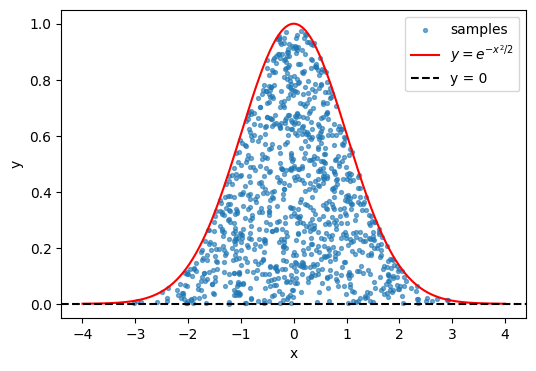

In [44]:
import matplotlib.pyplot as plt

n = 1000
x = np.random.normal(0, 1, size=n)
u = np.random.uniform(0, 1, size=n)
y = u * np.exp(-x**2 / 2)

plt.figure(figsize=(6,4))
plt.scatter(x, y, s=8, alpha=0.6, label="samples")
xx = np.linspace(min(x.min(), -4), max(x.max(), 4), 400)
plt.plot(xx, np.exp(-xx**2/2), color="red", label=r"$y = e^{-x^2/2}$")
plt.axhline(0, color="black", linestyle="--", label="y = 0")
plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.show()


<hr>

**(b)** Next, suppose we want to sample points which are uniformly distributed on the set $\{(x,y)\in\mathbb{R}^2|x^2+y^2 = 1\}$ (i.e., on the *circumference* of the unit circle). One way to do so may be to generate points $(U_i,V_i)$ uniformly in $[-1,1]^2$ (like in the first homework), and then *project* them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{U_i}{\sqrt{U_i^2+V_i^2}},\frac{V_i}{\sqrt{U_i^2+V_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Try checking the histogram of their angles (i.e., the histogram of $\theta_i = \tan^{-1}(Y_i/X_i)$).

<hr>

## Ans.

From the histogram, it is clear that these points are not uniformly distributed on the circumference of the circle.

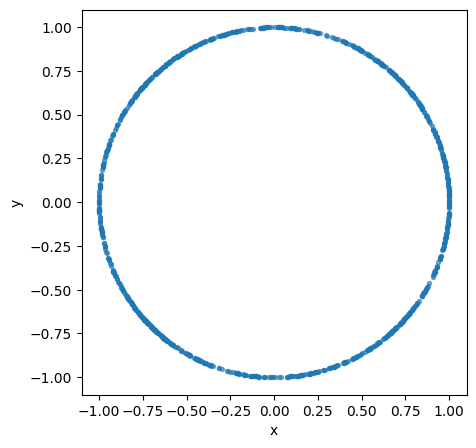

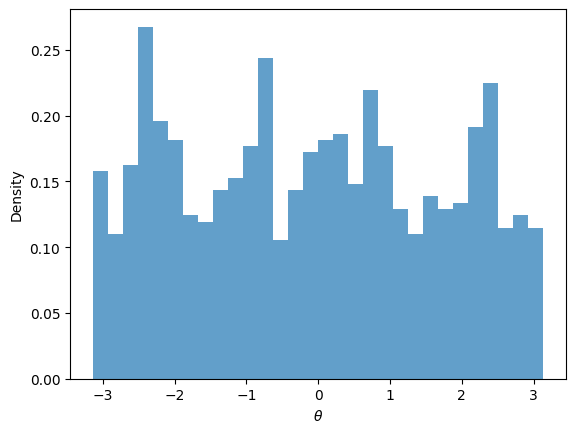

In [45]:
n = 1000
U = np.random.uniform(-1, 1, size=n)
V = np.random.uniform(-1, 1, size=n)

X = U / np.sqrt(U**2 + V**2)
Y = V / np.sqrt(U**2 + V**2)

plt.figure(figsize=(5,5))
plt.scatter(X, Y, s=8, alpha=0.6)
plt.gca().set_aspect('equal')
plt.xlabel("x"); plt.ylabel("y")
plt.show()

theta = np.arctan2(Y, X)
plt.hist(theta, bins=30, density=True, alpha=0.7)
plt.xlabel(r"$\theta$")
plt.ylabel("Density")
plt.show()


<hr>

**(c)** Next, generate points $(Z_i,W_i)$ as independent standard normals (i.e., $(Z_i,W_i)\sim \mathcal{N}(0,I_2)$), and again project them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{Z_i}{\sqrt{Z_i^2+W_i^2}},\frac{W_i}{\sqrt{Z_i^2+W_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Again, check the histogram of their angles $\theta_i$. Can you explain the difference between parts (b) and (c)?

<hr>

## Ans.

From the histogram, the points are uniform on the circumference. For (c), in polar coordinates $(R,\Theta)$ for a bivariate standard normal,
$$
f_{R,\Theta}(r,\theta)=\frac{1}{2\pi}\,r\,e^{-r^{2}/2},
$$
which is independent of $\theta$. Hence
$
\Theta \sim \text{Uniform}(-\pi,\pi],
$
giving a uniform distribution on the circle.

In (b), when sampling $(U,V)$ uniformly in $[-1,1]^2$, more area in the square maps to directions near the diagonals, so the induced angle distribution is not uniform.


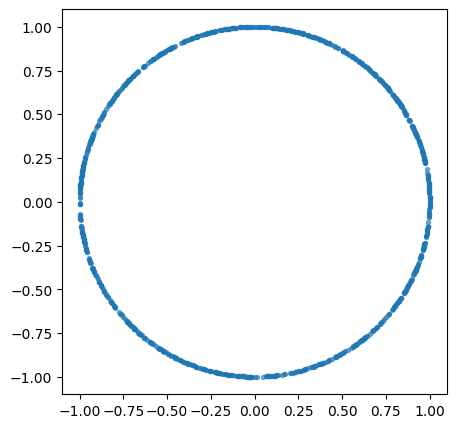

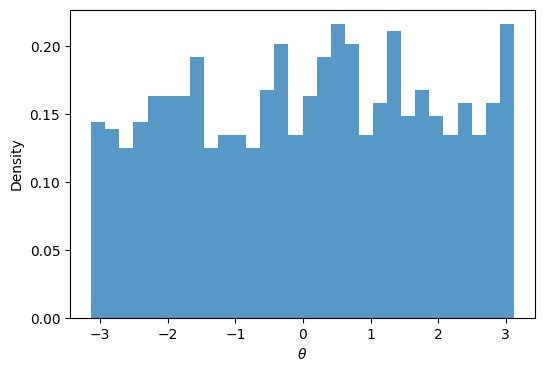

In [46]:
n = 1000
Z = np.random.normal(size=n)
W = np.random.normal(size=n)
R = np.sqrt(Z**2 + W**2)
X = Z / R
Y = W / R

plt.figure(figsize=(5,5))
plt.scatter(X, Y, s=8, alpha=0.6)
ax = plt.gca()
ax.set_aspect('equal')
theta = np.arctan2(Y, X)

plt.figure(figsize=(6,4))
plt.hist(theta, bins=30, density=True, alpha=0.75)
plt.xlabel(r"$\theta$")
plt.ylabel("Density")
plt.show()


<hr><hr>

# Question 3: Multivariate normals, and some finance (20 points)


Assume the following means and covariance matrix for the net annual returns (annual returns after accounting for inflation) on three investments:

$$\boldsymbol{\mu}=
\begin{bmatrix}
    \mu_{\text{U.S. stocks}}\\
    \mu_{\text{U.S. bonds}}\\
    \mu_{\text{EM bonds}}
\end{bmatrix}=
\begin{bmatrix}
    0.14 \\
    0.07 \\
    0.16\\
\end{bmatrix},$$

Moreover, we have $\sigma^2_{\text{U.S. stocks}}=0.0625, \sigma^2_{\text{U.S. bonds}}=0.01$ and $\sigma^2_{\text{EM bonds}}=0.09$. Assuming all three instruments are independent of each other, what is the probability that all three financial products simultaneously yield a positive return?


<hr>

## Ans.

Assume independence and normal returns. For an instrument with  
$X \sim \mathcal N(\mu,\sigma^2),$
we have  
$
\mathbb P(X>0)=\Phi\!\left(\frac{\mu}{\sigma}\right).
$

Thus, the required probability $ =\prod_{j=1}^3 \Phi\!\left(\frac{\mu_j}{\sigma_j}\right),$
$
\frac{\mu_1}{\sigma_1} = \frac{0.14}{0.25} = 0.56, \qquad
\frac{\mu_2}{\sigma_2} = \frac{0.07}{0.10} = 0.70, \qquad
\frac{\mu_3}{\sigma_3} = \frac{0.16}{0.30} \approx 0.5333.
$

Therefore,  
$
\mathbb P(\text{all}>0)
= \Phi(0.56)\,\Phi(0.70)\,\Phi(0.5333)
\approx 0.7123 \times 0.7580 \times 0.7031
\approx 0.3796.
$

Thus, the required probability is $37.96\%$. 

<hr>

**(b)** Next, assume that the assets are not independent, but rather, have covariance matrix
$$\boldsymbol{\Sigma}=
\begin{bmatrix}
    0.0625 & -0.01 & 0.0375 \\
    -0.01 & 0.01 & -0.015 \\
    0.0375 & -0.015 & 0.09
\end{bmatrix}.$$

Using simulation, estimate the probability that all three financial products simultaneously yield a positive return.
For the purposes of this problem, you are **not allowed** to use the Python function ${\tt numpy.random.multivariate\_normal}$, but rather, should generate *independent* normal rvs, and then apply the method(s) discussed in class.
In particular, you can compute the Cholesky decomposition of the covariance matrix using the Python function ${\tt scipy.linalg.cholesky(sigma, lower=True)}$.
<hr>

## Ans.



In [47]:
from scipy.linalg import cholesky

np.random.seed(0)

mu = np.array([0.14, 0.07, 0.16])
Sigma = np.array([[0.0625, -0.01,   0.0375],
                  [-0.01,   0.01,  -0.015],
                  [0.0375, -0.015,  0.09]])

L = cholesky(Sigma, lower=True)

n = 10000000
Z = np.random.normal(size=(n, 3))
X = mu + Z @ L.T

p = np.mean((X > 0).all(axis=1))
print(f"Estimated probability: {p:.4f}")


Estimated probability: 0.3705


<hr><hr>

# Question 4: Covariance and copulas (30 points)

In general (i.e., apart from multivariate normals), *there is no closed form formula for generating rvs with given marginals and given covariance matrix*. However, a popular heuristic is the so-called *Gaussian copula trick*, which is widely used in finance. In this question, we will try and get a sense of how we can generate correlated uniforms, and how the Gaussian copula trick works.

<hr>

**(a)** We will first try and make a method for generating two correlated uniform random variables $V_1$, $V_2$ with mean $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0$, variance $Var(V_1)=Var(V_2)=1$, and covariance $Cov( V_1, V_2 ) = \sigma_{12}$ (for some given $\sigma_{12}\geq 0$).

For what $\alpha,\beta\in\mathbb{R}$ does a uniform distribution on $[\alpha,\beta]$ have mean $0$ and variance $1$.

<hr>

## Ans.

$$
\mathbb E[X]=\frac{\alpha+\beta}{2}=0 \;\;\Rightarrow\;\; \beta=-\alpha.
$$

$$
\mathrm{Var}(X)=\frac{(\beta-\alpha)^2}{12}=1.
$$

$$
\frac{(-\alpha-\alpha)^2}{12}=\frac{(2\alpha)^2}{12}
=\frac{4\alpha^2}{12}=\frac{\alpha^2}{3}=1
\;\Rightarrow\;\; \alpha^2=3.
$$

Taking $\alpha<0<\beta$ (from $\beta=-\alpha$),
$$
\alpha=-\sqrt{3},\qquad \beta=\sqrt{3}.
$$

<hr>

**(b)** Next, generate rvs $X_1,X_2\sim Uniform[\alpha, \beta]$ i.i.d (with $\alpha,\beta$ from previous part), and also sample $B\sim Bernoulli(p)$. Define:
\begin{align*}
	V_1 = X_1 \qquad,\qquad
	V_2 = (1-B)X_1+BX_2 = \begin{cases} X_1 & \text{ if $B = 0$} \\ X_2 & \text{ if $B = 1$} \end{cases}
	\end{align*}

What is $\mathbb{E}[V_2]$ and $Var(V_2)$?

<hr>

## Ans.

$\mathbb E[X_i]=0$ and $\mathrm{Var}(X_i)=1$.

$ \mathbb E[V_2] = \mathbb E[\mathbb E[V_2 \mid B]] = (1-p)\mathbb E[X_1] + p \mathbb E[X_2] = (1-p)\cdot 0 + p\cdot 0 = 0. $

Using the law of total variance,  
$ \mathrm{Var}(V_2) = \mathbb E[\mathrm{Var}(V_2 \mid B)] + \mathrm{Var}(\mathbb E[V_2 \mid B]). $  

The second term is $0$ since $ \mathbb E[V_2 \mid B]=0 $ for both $B=0,1$.  
The first term is $ \mathbb E[\mathrm{Var}(V_2 \mid B)] = (1-p)\mathrm{Var}(X_1) + p\,\mathrm{Var}(X_2) = (1-p)\cdot 1 + p\cdot 1 = 1. $

Thus, $ \mathbb E[V_2]=0, \quad \mathrm{Var}(V_2)=1. $


<hr>

**(c)** For what value of $p$ do we get $Cov(V_1, V_2 )=\sigma_{12}$ (for $\sigma_{12}\geq 0$)?

<hr>

## Ans.

We have $V_1 = X_1$ and $V_2 = (1-B)X_1 + B X_2$.  

$\mathrm{Cov}(V_1, V_2) = \mathrm{Cov}\bigl(X_1,\,(1-B)X_1 + B X_2\bigr).$

$
\mathrm{Cov}(V_1, V_2)
= \mathrm{Cov}(X_1,(1-B)X_1)+\mathrm{Cov}(X_1,BX_2).
$

The second term is $0$ since $X_1$ is independent of both $B$ and $X_2$.  
For the first term:
$
\mathrm{Cov}(X_1,(1-B)X_1)
= \mathbb E[(1-B)X_1^2]-\mathbb E[X_1]\mathbb E[(1-B)X_1]
= (1-p)\mathbb E[X_1^2]
= (1-p)\mathrm{Var}(X_1)
= 1-p.
$

Thus
$
\mathrm{Cov}(V_1,V_2)=1-p.
$

$
1 - p = \sigma_{12} \quad \Rightarrow \quad p = 1 - \sigma_{12}.
$

Thus, $p = 1 - \sigma_{12}$.


<hr>

**(d)** Create a function to generate two correlated uniform random variables $V_1$, $V_2$ such that $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0,Var(V_1)=Var(V_2)=1$ and $Cov( U_1, U_2 ) = \sigma_{12}$. Use this to show a scatter plot of $(V_1,V_2)$ for correlation values $\sigma_{12}=0,0.25,0.5,0.75$ and $1$.

<hr>

## Ans.

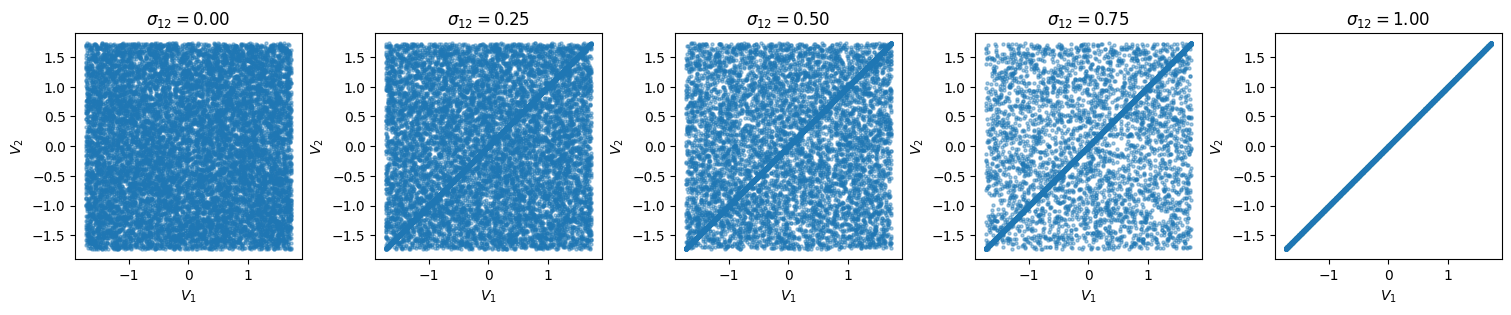

In [48]:
def f(n, sig):
    a, b = -np.sqrt(3), np.sqrt(3)
    X1 = np.random.uniform(a, b, n)
    X2 = np.random.uniform(a, b, n)
    p = 1 - sig
    B = np.random.binomial(1, p, n)
    V1 = X1
    V2 = (1 - B) * X1 + B * X2
    return V1, V2

n = 15000
sigmas = [0, 0.25, 0.5, 0.75, 1.0]
fig, axs = plt.subplots(1, len(sigmas), figsize=(15, 3), constrained_layout=True)

for ax, s in zip(axs, sigmas):
    v1, v2 = f(n, s)
    rho = np.corrcoef(v1, v2)[0, 1]
    ax.scatter(v1, v2, s=5, alpha=0.4)
    ax.set_title(rf"$\sigma_{{12}}={s:.2f}$")
    ax.set_xlabel("$V_1$")
    ax.set_ylabel("$V_2$")
    ax.set_aspect("equal")

plt.show()

<hr>

**(e)** Using the above function, compute $\mathbb{P}[V_1\leq 0,V_2\leq 0]$ for the case when $\sigma_{12}=0.5$ (in a financial application, this can correspond to *both* $V_1$ and $V_2$ 'defaulting').

<hr>

## Ans.

In [49]:
n = 200000
sig = 0.5

v1, v2 = f(n, sig)
p = np.mean((v1 <= 0) & (v2 <= 0))
print(f"Required probability = {p:.4f}")


Required probability = 0.3749


<hr>

**(f)** The Gaussian copula trick is based on first generating a multivariate normal vector with given covariance matrix $\Sigma$, and then using inversion to convert it to a vector of uniform rvs, which can then used to generate the desired rvs. We now demonstrate this in the above setting.

Let $\phi(\cdot)$ denote the 1-d normal cdf. Generate $(Z_1,Z_2)$ as multivariate normals with covariance
$\Sigma =\begin{pmatrix}
		1 & 0.5 \\
		0.5 & 1
	\end{pmatrix}$,
and define $W_1 = \alpha + (\beta-\alpha)\phi(Z_1)$ and $W_2 = \alpha + (\beta-\alpha)\phi(Z_2)$.

Argue $W_1$, $W_2$ are uniform on $[\alpha,\beta]$ (and hence $\mathbb{E}[W_1]=\mathbb{E}[W_2]=0,Var(W_1)=Var(W_2)=1$). Next, for $\sigma_{12}=0.5$ and $\alpha,\beta$ as above, write a function to generate $W_1,W_2$ as described, and use these to plot the scatter plot, and compute $\mathbb{P}[W_1\geq 0,W_2\geq 0]$.

<hr>

## Ans.

For $u\in(0,1)$,
$
\Pr(\phi(Z_i)\le u)=\Pr(Z_i\le \phi^{-1}(u))=\phi(\phi^{-1}(u))=u,
$

so $\phi(Z_i)\sim\mathrm{Unif}(0,1)$. For $t\in[\alpha,\beta]$,
$
\Pr(W_i\le t) = F_{W}(t) =\Pr\!\left(\phi(Z_i)\le \frac{t-\alpha}{\beta-\alpha}\right)
=\frac{t-\alpha}{\beta-\alpha},
$

the pdf is
$
f_{W}(t)=F_W'(t)=\frac{1}{\beta-\alpha}\quad\text{for }t\in(\alpha,\beta),
$
and
$
f_{W}(t)=0\ \text{for}t\notin[\alpha,\beta].
$
Thus, $W_i\sim \mathrm{Unif}[\alpha,\beta]$.


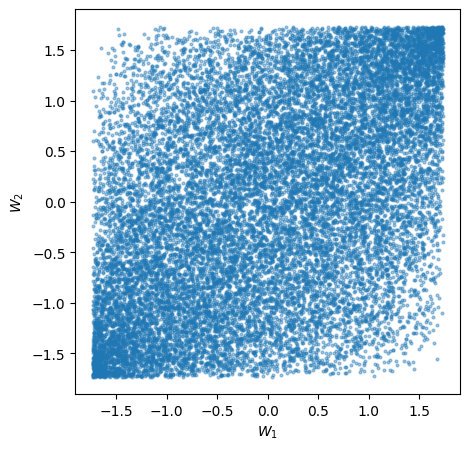

P[W1 ≥ 0, W2 ≥ 0] (rho=0.5): 0.3323


In [50]:
from scipy.stats import norm

def gen_gaussian_copula_uniform(n, rho, a=-np.sqrt(3), b=np.sqrt(3)):
    L = np.linalg.cholesky(np.array([[1.0, rho],[rho, 1.0]]))
    Z = np.random.standard_normal((n,2)) @ L.T
    U = norm.cdf(Z)
    W = a + (b - a) * U
    return W[:,0], W[:,1]

n = 20000
rho = 0.5
W1, W2 = gen_gaussian_copula_uniform(n, rho)

plt.figure(figsize=(5,5))
plt.scatter(W1, W2, s=4, alpha=0.4)
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel("$W_1$"); plt.ylabel("$W_2$")
plt.show()

p = np.mean((W1 >= 0) & (W2 >= 0))
print(f"P[W1 ≥ 0, W2 ≥ 0] (rho=0.5): {p:.4f}")
